Dataset Shape: (2976, 25)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sample Index            2560 non-null   float64
 1    EXG Channel 0          2560 non-null   float64
 2    EXG Channel 1          2560 non-null   float64
 3    EXG Channel 2          2560 non-null   float64
 4    EXG Channel 3          2560 non-null   float64
 5    EXG Channel 4          2560 non-null   float64
 6    EXG Channel 5          2560 non-null   float64
 7    EXG Channel 6          2560 non-null   float64
 8    EXG Channel 7          2560 non-null   float64
 9    Accel Channel 0        2560 non-null   float64
 10   Accel Channel 1        2560 non-null   float64
 11   Accel Channel 2        2560 non-null   float64
 12   Other                  2560 non-null   float64
 13   Other.1                2560 non-null   float64
 14  

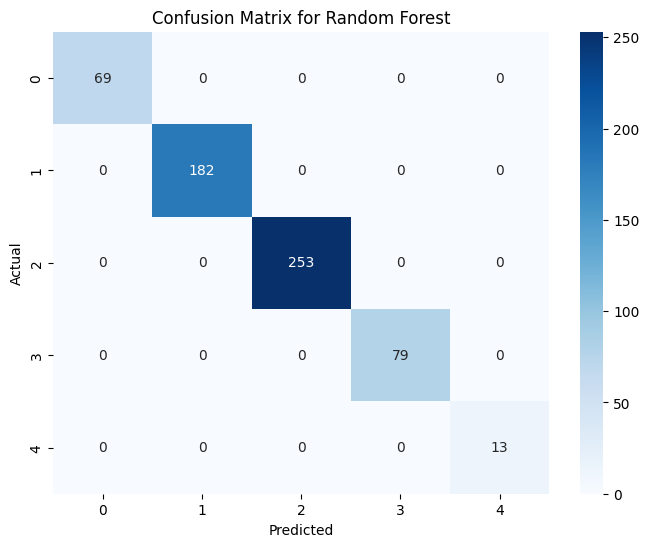


Support Vector Machine:
Accuracy: 0.9664429530201343
F1 Score: 0.9646965926301784
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        69
           1       0.96      0.99      0.98       182
           2       0.99      0.97      0.98       253
           3       0.90      0.97      0.93        79
           4       1.00      0.46      0.63        13

    accuracy                           0.97       596
   macro avg       0.97      0.87      0.90       596
weighted avg       0.97      0.97      0.96       596



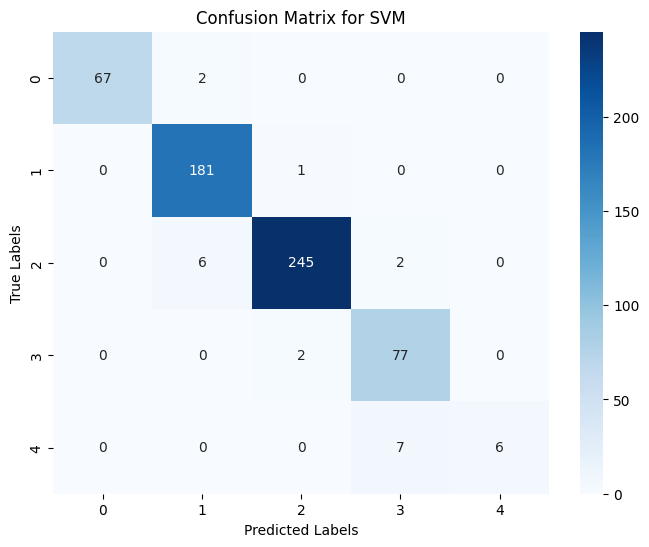

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data_path = "rest_s1.csv"
data = pd.read_csv(data_path)

# Initial Exploration
print("Dataset Shape:", data.shape)
print("Dataset Info:")
data.info()
print("\nSample Data:")
print(data.head())

# Step 1: Preprocessing
# Separate numeric and non-numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns

# Handle missing values for numeric columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Encode non-numeric columns (if any)
if len(non_numeric_columns) > 0:
    for column in non_numeric_columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column].astype(str))

# Create Target Column as Combination of Acceleration Channels
# Compute the magnitude of acceleration
if all(col in data.columns for col in [' Accel Channel 0', ' Accel Channel 1', ' Accel Channel 2']):
    data['target_column'] = np.sqrt(
        data[' Accel Channel 0']**2 + data[' Accel Channel 1']**2 + data[' Accel Channel 2']**2
    )
else:
    raise ValueError("Missing required Accel Channel columns: [' Accel Channel 0', ' Accel Channel 1', ' Accel Channel 2']")

# Bin target column into categories
data['target_column'] = pd.cut(data['target_column'], bins=5, labels=[0, 1, 2, 3, 4])

# Split features and target
X = data.drop(columns=['target_column'])
y = data['target_column']

# Step 2: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train ML Models
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Evaluate Models
# Random Forest
rf_pred = rf_model.predict(X_test)
print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, rf_pred))

rf_pred = rf_model.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, rf_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Optional: Calculate ROC-AUC if it's a binary classification problem
if len(y.unique()) == 2:
    rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, rf_pred_proba)
    print("ROC-AUC Score:", roc_auc)


rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model.fit(X_train, y_train)


# SVM
svm_pred = svm_model.predict(X_test)
print("\nSupport Vector Machine:")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print("F1 Score:", f1_score(y_test, svm_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, svm_pred))

# Confusion Matrix for SVM
svm_cm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
